In [13]:
!pip install google-play-scraper Sastrawi nltk wordcloud pandas matplotlib

Scraping
Jumlah ulasan yang diambil: 1500
Case folding & cleaning
Normalisasi
Hapus huruf berulang
Tokenisasi & hapus duplikat
Stopword removal & filtering
Hapus kata pendek (<3 huruf)
Stemming
Generate n-grams (unigram, bigram, trigram)
WordCloud


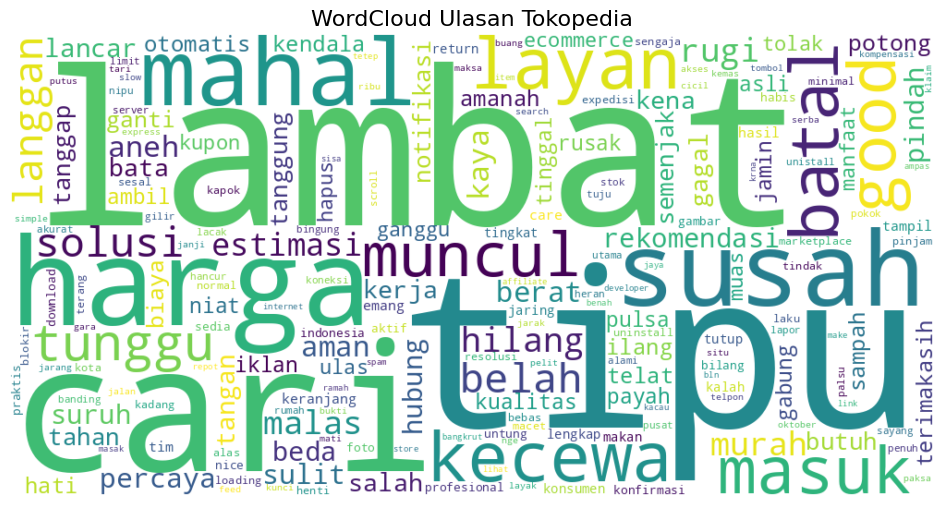

Menyimpan hasil akhir ke 'hasil_tokopedia_final.xlsx' ...
Selesai. File tersimpan: hasil_tokopedia_final.xlsx


In [12]:
try:
    import pkg_resources
    required = {'google_play_scraper', 'Sastrawi', 'nltk', 'wordcloud', 'pandas', 'matplotlib'}
    installed = {pkg.key for pkg in pkg_resources.working_set}
    missing = required - installed
    if missing:
        import subprocess, sys
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', *missing])
except Exception:
    pass

import re
import pandas as pd
import datetime
from collections import OrderedDict
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.util import ngrams
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from google_play_scraper import reviews, Sort
from wordcloud import WordCloud

nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)

APP_ID = 'com.tokopedia.tkpd'
OUTPUT_FILENAME = 'hasil_tokopedia_final.xlsx'
MAX_REVIEWS_TO_FETCH = 1500
BATCH_SIZE = 200

# Scraping
def fetch_reviews(app_id: str, max_reviews: int = 1000, batch_size: int = 200, lang='id', country='id'):
    all_reviews = []
    cont_token = None
    fetched = 0
    while fetched < max_reviews:
        to_fetch = min(batch_size, max_reviews - fetched)
        try:
            result, cont_token = reviews(
                app_id,
                lang=lang,
                country=country,
                sort=Sort.NEWEST,
                count=to_fetch,
                continuation_token=cont_token
            )
        except Exception as e:
            print("Error saat memanggil google_play_scraper:", e)
            break

        if not result:
            break

        all_reviews.extend(result)
        fetched += len(result)

        if not cont_token:
            break

    if len(all_reviews) > max_reviews:
        all_reviews = all_reviews[:max_reviews]

    return all_reviews

def cleaning_text(text: str) -> str:
    text = str(text).casefold()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

NORMALIZATION_DICT = {
      "gk": "tidak", "ga": "tidak", "gak": "tidak", "nggak": "tidak", "ngga": "tidak","tao":"tau","mao":"mau","errorbuka":"error buka",
      "kga": "tidak", "tdk": "tidak", "ngk": "tidak","apk":"aplikasi","nggk":"tidak","sekalisama":"sekali sama",
      "bgt": "banget", "bngt": "banget", "bgttt": "banget", "bangt": "banget","jossd":"bagus",
      "bgtu": "begitu", "parahh": "parah",
      "nungu": "tunggu", "nunggu": "tunggu", "gua": "saya", "gw": "saya", "lu": "kamu", "loe": "kamu",
      "bener": "benar", "benerin": "benarkan", "bagusan": "lebih bagus", "makin": "semakin","kopan":"kupon","diskonya":"diskonnya","pagiriman":"pengiriman",
      "beneran": "benar", "biar": "agar",
      "dpt": "dapat", "dapet": "dapat", "dgn": "dengan", "dg": "dengan", "dgnnya": "dengannya","awaludh":"awal udah","kwalitas":"kualitas",
      "dr": "dari", "drpd": "daripada", "dti": "di","mlu":"mulu",
      "tokped": "tokopedia", "toped": "tokopedia", "toko pedia": "tokopedia","sya":"saya",
      "tokpedcard": "kartu tokopedia", "ditokped": "di tokopedia",
      "bug": "error", "buggy": "error", "bugnya": "error", "eror": "error", "ngebug": "error","nomer":"nomor",
      "ngehang": "macet", "hang": "macet", "stuck": "macet","pake":"pakai",
      "ok": "oke", "okee": "oke", "okey": "oke", "okeeey": "oke", "okeey": "oke",
      "jos": "bagus", "siip": "sip", "top": "bagus", "mantab": "mantap", "mantep": "mantap",
      "kmrn": "kemarin", "skrg": "sekarang", "bsk": "besok", "besok2": "besok",
      "nnti": "nanti", "ntar": "nanti",
      "seler": "seller", "seler": "seller", "sopi": "shopee","sono":"sana",
      "bnyak": "banyak", "bnyk": "banyak", "brg": "barang", "brng": "barang",
      "yg": "yang", "ny": "nya", "nyari": "mencari", "nyampe": "sampai", "smpe": "sampai",
      "sm": "sama", "sma": "sama",
      "msh": "masih", "mshh": "masih", "mshnya": "masih", "mshnyaa": "masih",
      "trs": "terus", "trus": "terus", "lg": "lagi", "lgi": "lagi","cuman":"cuma","cuma":"hanya",
      "mo": "mau", "jd": "jadi", "jdnya": "jadinya", "jg": "juga", "jgn": "jangan",
      "bwt": "buat", "tlg": "tolong", "plis": "tolong", "tolonglah": "tolong","batalin":"batal",
      "mksh": "makasih", "maksh": "makasih", "trimakasih": "terima kasih","hapu":"hapus","krn":"karena",
      "tq": "terima kasih", "thx": "terima kasih", "thxya": "terima kasih ya","sellernya":"seller",
      "bgs": "bagus", "bgus": "bagus", "bgsx": "bagus", "bagusan": "lebih bagus","blm":"belum","team":"tim","lelet": "lambat", "lemot": "lambat", "cepet": "cepat", "cpt": "cepat","uninstal":"unistall",
      "mhl": "mahal", "br": "baru", "brtambah": "bertambah","udh":"udah","promonya":"promo nya","gajelas":"ga jelas",
      "beliin": "membelikan", "beliinlah": "membelikan", "bikin": "membuat","plus":"tambah","kagak":"tidak",
      "ngirim": "mengirim", "nyesel": "menyesal", "dtg": "datang", "hapus": "hapus","sampe":"sampai",
      "unistal": "uninstall", "unistalin": "uninstall", "ngunistal": "uninstall","komplen":"komplain","complain":"komplain",
      "dll": "dan lain lain", "tsb": "tersebut", "tsbt": "tersebut","dlu":"dulu","kalo":"kalau","balikin":"kembali kan",
      "aq": "aku", "q": "aku", "sy": "saya", "km": "kamu", "min": "admin","cod":"cash on delivery","scam":"penipuan",
      "cs": "customer service", "jne": "jasa pengiriman jne", "jnt": "jasa pengiriman jnt","gede":"besar",
      "refund": "dikembalikan", "pasilitasnanya": "layanannya","duit":"uang","ngasih":"beri","tgl":"tanggal",
      "smoga": "semoga", "moga": "semoga", "moga2": "semoga","knp":"kenapa","doang":"hanya","males":"malas","tambahin":"tambah kan",
      "utk": "untuk", "kpd": "kepada", "pdhl": "padahal", "bbrp": "beberapa", "bbrapa": "beberapa","blanja":"belanja",
      "dlm": "dalam", "bkn": "bukan", "td": "tadi", "hrs": "harus","ongkirnya":"ongkir","notif":"notifikasi","muter":"ber putar",
      "kayak": "seperti", "kek": "seperti", "kesini": "sini", "mles": "malas", "dll":"dan lain lain","skrng":"sekarang","lbh":"lebih"
}

def normalisasi_kata(text: str) -> str:
    words = str(text).split()
    normalized = [NORMALIZATION_DICT.get(w.lower(), w.lower()) for w in words]
    return ' '.join(normalized)

def hapus_huruf_berulang(text: str) -> str:
    return re.sub(r'(.)\1{2,}', r'\1', str(text))

# stopwords
stopwords_indo = set(stopwords.words('indonesian'))
stopwords_eng = set(stopwords.words('english'))
stopwords_nltk = stopwords_indo.union(stopwords_eng)
CUSTOM_STOPWORDS = {  "nyanya",
    "yg", "dg", "rt", "dgn", "ny", "nya", "d", "klo", "yang", "dan", "di", "ke", "dari", "untuk", "dengan","itu","noh","kon","hadeh",
    "pada", "itu", "ini", "karena", "kalau", "jadi", "agar", "seperti", "ada", "atau", "juga","woy","shop",
    "sudah", "belum", "akan", "dapat", "saja", "lagi", "hanya", "saat", "buat", "bisa", "masih",
    "bukan", "setelah", "tanpa", "mau", "dulu", "lah", "ya", "kok", "kan", "pun", "oleh", "sama","apk","aplikasi",
    "mungkin", "terlalu", "si", "jd", "jgn", "sdh", "utk", "tau", "tdk", "biar", "ke", "n", "t","sdrvctao",
    "saya", "aku", "kamu", "dia", "mereka", "kami", "kita", "gua", "gw", "loe", "lu", "nih", "lho",
    "yah", "oh", "eh", "nah", "loh", "yaudah", "deh", "dong", "sih", "tuh", "aja","udah",
    "haha", "hehe", "wkwk", "wkwkwk", "lol", "jir", "cuy", "anjay", "mantap", "bagus","contoh","ninja",
    "baik", "top", "best", "terbaik", "super", "oke", "ok", "okey", "okee", "okej", "okeeey",
    "okeey", "sip", "lumayan", "bagusan", "bener", "beneran", "banget", "bgt", "bngt", "amat","karena",
    "sekali", "cuma", "parah", "jelek", "buruk", "keren", "ajaib", "bagusnya", "bagus2",
    "bagus banget", "okeee","dil","tpi","jnt","juta","jne",
    "hari", "kemarin", "tadi", "besok", "minggu", "bulan", "tahun", "jam", "detik", "menit","karna","krn",
    "alhamdulillah", "amin", "semoga", "sukses", "terima", "kasih", "thank", "thanks", "thankyou",
    "makasih", "doa", "moga", "harap", "harapnya", "selamat", "pagi", "siang", "malam", "dear",
    "barang", "produk", "toko", "belanja", "beli", "jual", "pakai", "pesan", "paket", "transaksi",
    "akun", "uang", "saldo", "order", "pesanan", "customer", "service", "seller", "buyer",
    "tokopedia", "tokped", "toped", "shopee", "shoppe", "shope", "lazada", "bukalapak", "blibli",
    "tiktokshop", "tiktok", "gojek", "grab", "gopay", "gopaylater", "toko pedia", "app", "aplikasi",
    "fitur", "admin", "kurir", "ongkir", "ongkos", "layanan", "respon", "proses", "update",
    "kirim", "balik", "refund", "retur", "komplain", "cs", "chat", "bintang", "sistem", "user",
    "versi", "online", "verifikasi", "bot", "promo", "diskon", "gratis", "voucher", "fitur",
    "pesan", "pesanan", "service", "customer", "review", "rating", "reseller", "shoppe", "error",
    "eror", "kesalahan", "ulang","buat", "pas", "sesuai", "langsung", "data", "nama", "tanggal", "klik",
    "status", "isi", "tulis", "pencet", "cepat", "lama", "ubah", "kode","blom","alih","later","sekian",
    "versi", "akun", "email", "nomor", "pin", "alamat", "daftar", "menu","asa",
    "layanan", "service", "produk", "pesanan", "beli", "jual", "pakai","kan","in",
    "bayar", "saldo", "uang", "tarik", "tf", "transfer", "topup", "deposit", "rekening", "atm","kyk",
    "dana", "ovo", "gopay", "cash", "metode", "pembayaran", "transaksi", "nominal", "tagihan","doang",
    "ribet", "mudah", "gampang", "lama", "cepat", "baru", "sendiri", "sendirinya", "orang","oren",
    "sama", "karena", "punya", "udah", "lagi", "dan", "atau", "itu", "ini", "ada", "tidak","tolol","paylater",
    "ga", "gak", "nggak", "ngga", "enggak", "iya", "mau", "aja", "kayak", "coba", "mending","mah","gitu","ama",
    "tolong", "bantu", "kasih", "suka", "senang", "enak", "nyaman", "puas", "baiklah", "boleh","dah","aju","gin","sen","buka", "kali", "pilih", "sampai", "selesai", "data", "login", "akun", "cek", "nama",
    "isi", "menu", "halaman", "kode", "status", "versi", "nomor", "alamat", "tanggal","cashback",
    "produk", "fitur", "promo", "voucher", "bonus", "ekspedisi", "delivery", "checkout","filter","baca",
    "pesan", "pesanan", "jasa", "service", "transaksi", "metode", "nominal","sumpah","kocak","gila",
    "mulu", "jadi", "gimana", "bisa", "ada", "sama", "kalau", "karena", "harap","orange",
    "tolong", "mohon", "terima", "maaf", "saran", "ucapan","tokopediacare","adu","ampun","balas","atur","platform","card"
}
STOPWORDS_FINAL = stopwords_nltk.union(CUSTOM_STOPWORDS)

def remove_duplicates(tokens):
    return list(OrderedDict.fromkeys(tokens))

def filtering(tokens):
    filtered = []
    for token in tokens:
        token = re.sub(r'\d+', '', token.lower())
        token = re.sub(r'[^a-z]', '', token)
        if token and token not in STOPWORDS_FINAL:
            filtered.append(token)
    return filtered

# stemming
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stemming_text(text: str) -> str:
    text = re.sub(r'[^a-z\s]', '', str(text).lower())
    text = re.sub(r'\s+', ' ', text).strip()
    try:
        return stemmer.stem(text)
    except Exception:
        return text

def generate_ngrams_from_tokens(tokens, n):
    if not tokens:
        return []
    return [' '.join(gram) for gram in ngrams(tokens, n)]

def pipeline_and_save(app_id=APP_ID, output_file=OUTPUT_FILENAME, max_reviews=MAX_REVIEWS_TO_FETCH):
    print("Scraping")
    raw_reviews = fetch_reviews(app_id, max_reviews, BATCH_SIZE)
    if not raw_reviews:
        print("Tidak ada ulasan yang didapatkan. Periksa app_id atau koneksi internet.")
        return

    print(f"Jumlah ulasan yang diambil: {len(raw_reviews)}")

    df = pd.DataFrame(raw_reviews)
    use_cols = {}
    if 'reviewId' in df.columns:
        use_cols['reviewId'] = 'ReviewId'
    if 'userName' in df.columns:
        use_cols['userName'] = 'UserName'
    if 'score' in df.columns:
        use_cols['score'] = 'Score'
    if 'content' in df.columns:
        use_cols['content'] = 'Hasil Scrap'
    if 'at' in df.columns:
        use_cols['at'] = 'Tanggal'

    df = df[list(use_cols.keys())].rename(columns=use_cols)

    # Preprocessing
    print("Case folding & cleaning")
    df['Case Folding'] = df['Hasil Scrap'].astype(str).apply(lambda x: str(x).casefold())
    df['Cleaning'] = df['Case Folding'].apply(cleaning_text)

    print("Normalisasi")
    df['Normalisasi'] = df['Cleaning'].apply(normalisasi_kata)

    print("Hapus huruf berulang")
    df['Bersih'] = df['Normalisasi'].apply(hapus_huruf_berulang)

    print("Tokenisasi & hapus duplikat")
    df['Token Raw'] = df['Bersih'].apply(lambda x: word_tokenize(str(x)))
    df['No_Duplikat'] = df['Token Raw'].apply(remove_duplicates)

    print("Stopword removal & filtering")
    df['Stopwords_Removed'] = df['No_Duplikat'].apply(lambda tokens: [t for t in tokens if t.lower() not in STOPWORDS_FINAL])
    df['Filtering'] = df['Stopwords_Removed'].apply(filtering)
    df['Token Filtered Text'] = df['Filtering'].apply(lambda x: ' '.join(x))

    print("Hapus kata pendek (<3 huruf)")
    df['Bersih Akhir'] = df['Token Filtered Text'].apply(lambda s: ' '.join([w for w in str(s).split() if len(w) >= 3]))

    print("Stemming")
    df['Stemming'] = df['Bersih Akhir'].apply(stemming_text)

    print("Generate n-grams (unigram, bigram, trigram)")
    df['Token Stem'] = df['Stemming'].apply(lambda x: word_tokenize(str(x)))
    df['Unigram'] = df['Token Stem'].apply(lambda toks: generate_ngrams_from_tokens(toks, 1))
    df['Bigram'] = df['Token Stem'].apply(lambda toks: generate_ngrams_from_tokens(toks, 2))
    df['Trigram'] = df['Token Stem'].apply(lambda toks: generate_ngrams_from_tokens(toks, 3))

    def filter_bigram_list(bigrams):
        result = []
        for bg in bigrams:
            parts = bg.split()
            if len(parts) == 2 and parts[0] not in STOPWORDS_FINAL and parts[1] not in STOPWORDS_FINAL:
                result.append(bg)
        return result

    df['Bigram_Filtered'] = df['Bigram'].apply(filter_bigram_list)

    # WordCloud
    print("WordCloud")
    df['Token_Filtered_List'] = df['Stemming'].apply(
        lambda x: [w for w in word_tokenize(str(x)) if w not in STOPWORDS_FINAL and len(w) >= 3]
    )
    all_tokens = [t for tokens in df['Token_Filtered_List'] for t in tokens if str(t).strip() != '']
    all_text = ' '.join(all_tokens)

    if all_text.strip():
        wc = WordCloud(width=1000, height=500, background_color='white', collocations=False).generate(all_text)
        plt.figure(figsize=(12, 6))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis('off')
        plt.title("WordCloud Ulasan Tokopedia", fontsize=16)
        plt.show()
    else:
        print("WordCloud: tidak ada token untuk ditampilkan.")

    final_cols = [
        'ReviewId', 'UserName', 'Score', 'Tanggal',
        'Hasil Scrap', 'Case Folding', 'Cleaning', 'Normalisasi',
        'Bersih', 'Token Raw', 'No_Duplikat', 'Stopwords_Removed', 'Filtering', 'Token Filtered Text',
        'Bersih Akhir', 'Stemming', 'Unigram', 'Bigram', 'Trigram', 'Bigram_Filtered'
    ]

    final_cols = [c for c in final_cols if c in df.columns]

    print(f"Menyimpan hasil akhir ke '{output_file}' ...")
    df[final_cols].to_excel(output_file, index=False)
    print("Selesai. File tersimpan:", output_file)

if __name__ == "__main__":
    pipeline_and_save()
